In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 9 2025

@author: Yaning
"""

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F # mainly for ReLU
import numpy as np
import copy
import re
from tqdm import tqdm
from transformers import BatchEncoding
import pickle
import torch.nn.functional as F

/home/yaning/Documents/python_env/llm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Model

tokenizer = AutoTokenizer.from_pretrained("dbmdz/german-gpt2")
model = GPT2Model.from_pretrained("dbmdz/german-gpt2")
model.to("cuda")
model.eval()

GPT2Model(
  (wte): Embedding(50265, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.0, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [29]:
with open('/home/yaning/Documents/LLM/skip_gram/winnetou_h.txt', 'r') as file:
    h_text = file.read()

with open('/home/yaning/Documents/LLM/skip_gram/winnetou_s.txt', 'r') as file:
    s_text = file.read()

In [4]:
processed_s_text = s_text.lower()
processed_s_text = re.sub(r'[.,]', " ", processed_s_text)
processed_s_text = re.sub(r'\s+', " ", processed_s_text)

processed_h_text = h_text.lower()
processed_h_text = re.sub(r'[.,]', " ", processed_h_text)
processed_h_text = re.sub(r'\s+', " ", processed_h_text)

processed_h_text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]+', '', processed_h_text)
processed_s_text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]+', '', processed_s_text)

In [5]:
# tokenise the sentences
tokens_h = tokenizer(processed_h_text)['input_ids']
tokens_s = tokenizer(processed_s_text)['input_ids']

Use rough batching

In [6]:
pad_index = 1

In [7]:
def create_batches(sequence1, sequence2, num_batches):
    # Calculate batch size based on the number of batches
    total_length = max(len(sequence1), len(sequence2))
    batch_size = total_length // num_batches
    if total_length % num_batches != 0:
        batch_size += 1  # Ensure no incomplete batches
    
    # Split sequences into batches
    batches1 = [sequence1[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
    batches2 = [sequence2[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
    # batches3 = [sequence3[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
    
    # Find the maximum length among the two sequences
    max_len1 = max(len(batch) for batch in batches1)
    max_len2 = max(len(batch) for batch in batches2)
    # max_len3 = max(len(batch) for batch in batches3)
    
    # Pad the sequences to have the same length across batches
    padded_batches1 = [batch + [pad_index] * (max_len1 - len(batch)) for batch in batches1]
    padded_batches2 = [batch + [pad_index] * (max_len2 - len(batch)) for batch in batches2]
    # padded_batches3 = [batch + [pad_index] * (max_len3 - len(batch)) for batch in batches3]
    
    return padded_batches1, padded_batches2


num_batches = 93
# num_batches = 3500

batches_h, batches_s = create_batches(tokens_h, tokens_s, num_batches)

print("Batch 1:", batches_h)
print("Batch 2:", batches_s)
# print("Batch 3:", batches_s_target)


Batch 1: [[339, 1006, 28500, 16931, 850, 1411, 444, 442, 364, 1587, 273, 1963, 1525, 292, 943, 921, 941, 992, 5606, 895, 1562, 286, 375, 1821, 442, 652, 608, 412, 13781, 5604, 286, 1090, 567, 12198, 941, 2083, 632, 2329, 921, 568, 468, 333, 1443, 1608, 87, 666, 3514, 313, 6868, 2010, 3897, 355, 568, 8650, 535, 426, 418, 1003, 20935, 356, 1084, 537, 362, 24595, 1782, 286, 41410, 1624, 542, 286, 11793, 524, 1061, 1007, 404, 9263, 453, 1011, 1894, 623, 286, 545, 12716, 442, 25228, 536, 362, 1331, 36291, 293, 2342, 6620, 1942, 292, 353, 5892, 16533, 4940, 364, 485, 27521, 542, 286, 385, 778, 282, 264, 43424, 292, 296, 20627, 16332, 2241, 567, 2362, 1762, 878, 404, 9263, 453, 1011, 292, 5892, 16533, 4940, 3616, 292, 426, 5072, 286, 16406, 545, 12716, 1087, 2010, 12958, 568, 1762, 7429, 3527, 2178, 545, 1862, 24182, 6982, 20756, 429, 292, 298, 315, 3071, 50150, 26078, 429, 14626, 4540, 8872, 943, 22068, 364, 286, 225, 3588, 30857, 1974, 2859, 282, 3342, 4677, 442, 784, 2241, 8045, 34997, 442

In [8]:
batch_size = len(batches_s[0])

Batch stuff myself

In [ ]:
train_h = []
# batch the tokens with ratio
ratio = len(tokens_s)/len(tokens_h)
# every 10 tokens of hochdeutsch is a batch
batch_size = 521
for i in range(len(tokens_h)-batch_size+1):
    temp = tokens_h[i:i+batch_size]
    temp.append(1)
    # temp.append(1)
    train_h.append(temp)

In [9]:
import random
train_s = []
for i in range(len(train_h)):
    batch_size_s = round(batch_size*ratio)
    center = (batch_size*0.5+0.5+i)*ratio
    chunk_begin = round(center - batch_size_s/2)
    chunk_end = round(center + batch_size_s/2)
    if chunk_end - chunk_begin != batch_size_s:
        random_number = random.randint(0, 1)
        if random_number == 0:
            chunk_begin = chunk_begin+1
        else:
            chunk_end = chunk_end-1
    
    if chunk_begin < 0:
        chunk_begin = 0
    if chunk_end > len(tokens_s)-1:
        chunk_end = len(tokens_s)-1
    
    temp = tokens_s[chunk_begin:chunk_end]
    while len(temp) < batch_size_s:
        temp.append(1)
    train_s.append(temp)

In [9]:
def normalise_matrix(m):
    m_mean = m.mean()
    m_std = m.std()
    m = (m-m_mean)/m_std
    return m

In [30]:
# add transition layer to the standard embedding
class TransitionLayer(nn.Module):
    def __init__(self, embedding_dim):
        super(TransitionLayer, self).__init__()
        # Trainable transition matrix to map standard to dialect
        self.transition_matrix = nn.Parameter(torch.randn(batch_size, embedding_dim))
    
    def forward(self, standard_embeddings):

        scaled_standard = normalise_matrix(standard_embeddings)

        scaled_transition = normalise_matrix(self.transition_matrix)

        added = scaled_standard + scaled_transition/1
        
        return added

# # multiply transition matrix with the standard embedding
# class TransitionLayer(nn.Module):
#     def __init__(self, embedding_dim):
#         super(TransitionLayer, self).__init__()
#         # Trainable transition matrix to map standard to dialect
#         self.transition_matrix = nn.Parameter(torch.randn(embedding_dim, embedding_dim))
    
#     def forward(self, standard_embeddings):

#         normalise_matrix(standard_embeddings)

        
#         transition_matrix_mean = self.transition_matrix.mean()
#         transition_matrix_std = self.transition_matrix.std()
#         scaled_transition = (self.transition_matrix - transition_matrix_mean) / transition_matrix_std
#         # self.transition_matrix = scaled_transition
        
#         return torch.matmul(standard_embeddings, self.transition_matrix)


# # attention transition matrix
# class TransitionLayer(nn.Module):
#     def __init__(self, embedding_dim):
#         super(TransitionLayer, self).__init__()
#         # Trainable transition matrix to map standard to dialect
#         self.query = nn.Parameter(torch.randn(embedding_dim, embedding_dim))
#         self.key = nn.Parameter(torch.randn(embedding_dim, embedding_dim))
#         self.value = nn.Parameter(torch.randn(embedding_dim, embedding_dim))
#         self.transition_matrix = nn.Parameter(torch.randn(embedding_dim, embedding_dim))
        
    
#     def forward(self, standard_embeddings):
#         attention_matrix = torch.matmul(self.query, self.key)/(10 ** 0.5)
#         attention_weights = F.softmax(attention_matrix, dim=-1)
#         transition_matrix = torch.matmul(attention_weights, self.value)
#         return torch.matmul(standard_embeddings, transition_matrix)
    

In [31]:
embedding_dim = model.config.hidden_size #768 dimensions
transition_layer = TransitionLayer(embedding_dim).to("cuda")

In [33]:
# Define Mean Squared Error loss
criterion = nn.MSELoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adam(transition_layer.parameters(), lr=0.01)
losses = []

# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    for batch in range(len(batches_h)):

        temp_h = BatchEncoding({
            'input_ids': torch.tensor(batches_h[batch]),
            'attention_mask': torch.tensor([1]*len(batches_h[batch]))
        }).to("cuda")
        temp_s = BatchEncoding({
            'input_ids': torch.tensor(batches_s[batch]),
            'attention_mask': torch.tensor([1]*len(batches_s[batch]))
        }).to("cuda")
        # print(type(temp_h))
        # Get standard language embeddings
        with torch.no_grad():
            standard_outputs = model(**temp_h)
            # print(standard_outputs.last_hidden_state)
            # standard_outputs = model.base_model(**standard_inputs, output_hidden_states=True)
            # standard_hidden_states = standard_outputs.hidden_states[-1]  # Last hidden state (batch_size, seq_len, hidden_size)
            standard_hidden_states = standard_outputs.last_hidden_state
            # print(standard_hidden_states.shape)

        # Get dialect embeddings (ground truth)
        with torch.no_grad():
            dialect_outputs = model(**temp_s)
            dialect_hidden_states = dialect_outputs.last_hidden_state
        
        # Apply the transition matrix to map standard to dialect space
        predicted_dialect_hidden_states = transition_layer(standard_hidden_states)
        # predicted_dialect_hidden_states = transition_layer(dialect_hidden_states)
        
        # loss = criterion(predicted_dialect_hidden_states, standard_hidden_states)
        loss = criterion(predicted_dialect_hidden_states, dialect_hidden_states)
        losses.append(loss)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


  0%|                                                                                                            | 0/10 [00:00<?, ?it/s]

 20%|████████████████████                                                                                | 2/10 [00:03<00:15,  1.92s/it]

Epoch [2/10], Loss: 1.1923


 40%|████████████████████████████████████████                                                            | 4/10 [00:07<00:11,  1.92s/it]

Epoch [4/10], Loss: 0.9739


 60%|████████████████████████████████████████████████████████████                                        | 6/10 [00:11<00:07,  1.93s/it]

Epoch [6/10], Loss: 0.7885


 80%|████████████████████████████████████████████████████████████████████████████████                    | 8/10 [00:15<00:03,  1.93s/it]

Epoch [8/10], Loss: 0.6377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]

Epoch [10/10], Loss: 0.5623


In [34]:
relocate = []
for i in losses:
    relocate.append(i.cpu().detach().numpy())

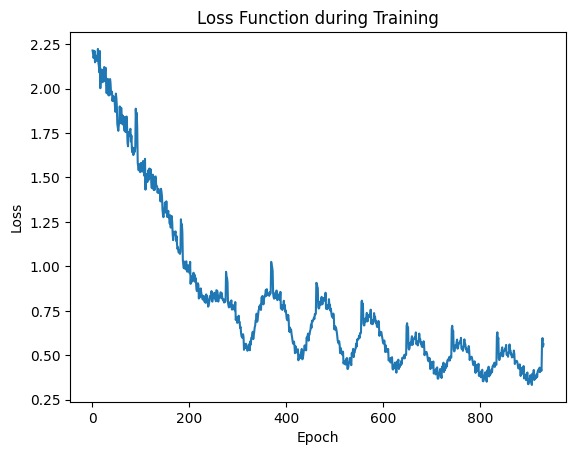

In [35]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(relocate) + 1), relocate, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function during Training')
# plt.legend()
# plt.savefig("loss_trans.png", dpi=300)
plt.show()

In [36]:
torch.save(transition_layer.state_dict(), 'transition_matrix_new.pth')

In [37]:
transition_layer.transition_matrix

Parameter containing:
tensor([[-0.5904, -0.5433, -0.5627,  ..., -0.4271, -0.1558, -0.1224],
        [-0.6428, -0.2056, -0.3881,  ..., -0.3695, -0.2542, -0.2047],
        [-0.4675, -0.2866, -0.6700,  ..., -0.6648, -0.1841, -0.1945],
        ...,
        [-0.6851, -0.0165, -1.0864,  ..., -0.5519, -0.4650, -0.1772],
        [-0.3884, -0.2912,  0.0386,  ..., -0.6313, -0.5292,  0.1062],
        [-0.1953, -0.2458, -0.8782,  ..., -0.5627, -0.6208, -0.1713]],
       device='cuda:0', requires_grad=True)